In [1]:
import open3d as o3d
import numpy as np

# Assuming 'blocks' and 'neighbors' are available and each block has XYZ information
def visualize_block_and_neighbors(block, neighbors):
    # Create Open3D PointCloud object for the block
    point_cloud_block = o3d.geometry.PointCloud()
    
    # Extract XYZ coordinates for the block
    xyz_block = block[:, :3]

    # Set points for the block point cloud
    point_cloud_block.points = o3d.utility.Vector3dVector(xyz_block)

    # Set block color to red (same color for all points)
    point_cloud_block.paint_uniform_color([1.0, 0.0, 0.0])

    # Create Open3D PointCloud object for the neighbors
    point_cloud_neighbors = o3d.geometry.PointCloud()

    # Extract XYZ coordinates for the neighbors (using neighbor indices to access the block points)
    if len(neighbors) > 0:
        xyz_neighbors = block[neighbors.flatten(), :3]
        point_cloud_neighbors.points = o3d.utility.Vector3dVector(xyz_neighbors)

        # Set neighbors color to blue (same color for all points)
        point_cloud_neighbors.paint_uniform_color([0.0, 0.0, 1.0])
        
        print(f"Number of neighbor points: {len(xyz_neighbors)}")
    else:
        print("No neighbor points found.")

    # Visualize both the block and its neighbors
    o3d.visualization.draw_geometries([point_cloud_block, point_cloud_neighbors])

# Visualize the first block of points and its neighbors
visualize_block_and_neighbors(blocks[1], neighbors[1])



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


NameError: name 'blocks' is not defined

In [2]:
import open3d as o3d
import numpy as np

# Assuming 'blocks' is available and each block has XYZ and potentially RGB information
def visualize_all_blocks(blocks):
    for i, block in enumerate(blocks):
        print(f"Visualizing block {i + 1}/{len(blocks)}")
        visualize_block(block)

def visualize_block(block):
    # Create Open3D PointCloud object
    point_cloud = o3d.geometry.PointCloud()

    # Extract XYZ coordinates
    xyz = block[:, :3]

    # Set points for the point cloud
    point_cloud.points = o3d.utility.Vector3dVector(xyz)

    # Check if RGB information is available
    if block.shape[1] >= 6:
        rgb = block[:, 3:6] / 255.0  # Assuming RGB values are between 0-255, normalize to 0-1
        point_cloud.colors = o3d.utility.Vector3dVector(rgb)

    # Visualize the point cloud
    o3d.visualization.draw_geometries([point_cloud])

# Visualize all blocks of points
visualize_all_blocks(blocks)


NameError: name 'blocks' is not defined

In [6]:
import open3d as o3d
import numpy as np

# Assuming 'blocks' and 'neighbors' are available and each block has XYZ and potentially RGB information
def visualize_block_and_neighbors(block, neighbors):
    # Create Open3D PointCloud object for the block
    point_cloud_block = o3d.geometry.PointCloud()
    print("ahoj")
    # Extract XYZ coordinates for the block
    xyz_block = block[:, :3]

    # Set points for the block point cloud
    point_cloud_block.points = o3d.utility.Vector3dVector(xyz_block)

    # Set block color to red (same color for all points)
    point_cloud_block.paint_uniform_color([1.0, 0.0, 0.0])

    # Create Open3D PointCloud object for the neighbors
    point_cloud_neighbors = o3d.geometry.PointCloud()

    # Extract XYZ coordinates for the neighbors
    xyz_neighbors = neighbors[:, :3]

    # Set points for the neighbors point cloud
    point_cloud_neighbors.points = o3d.utility.Vector3dVector(xyz_neighbors)

    # Set neighbors color to blue (same color for all points)
    point_cloud_neighbors.paint_uniform_color([0.0, 0.0, 1.0])

    # Visualize both the block and its neighbors
    o3d.visualization.draw_geometries([point_cloud_block, point_cloud_neighbors])

# Visualize the first block of points and its neighbors
visualize_block_and_neighbors(blocks[1], neighbors[1])


In [30]:
import h5py

# Replace with the path to your .h5 file
hdf5_path = r"C:\Users\lukas\Desktop\pointcloud_data.h5"

with h5py.File(hdf5_path, "r") as f:
    # List all datasets in the file
    print("Datasets in the file:")
    for name in f.keys():
        print(name, f[name].shape)

    # Accessing a specific dataset, e.g., 'blocks'
    blocks = f['blocks'][:]
    print("\nFirst block of points:\n", blocks[1])

    # Accessing labels and neighbors information similarly
    labels = f['labels'][:]
    neighbors = f['neighbors'][:]
    intensity = f['intensity'][:]
    
    print("\nFirst block of labels:\n", labels[1])
    print("\nFirst block of neighbor indices:\n", neighbors[1])
    print("\nFirst block of intensity:\n", intensity[1])

Datasets in the file:
blocks (76527, 1024, 3)
intensity (76527, 1024)
labels (0,)
rgb (76527, 1024, 3)

First block of points:
 [[-0.5095989  0.8547    -0.0416   ]
 [-0.502399   0.8715    -0.043499 ]
 [-0.508      0.9169989 -0.05     ]
 ...
 [-2.0165989  3.4196989 -0.1049989]
 [-1.925199   3.3884    -0.102499 ]
 [-1.853999   3.3903    -0.1018989]]


KeyError: "Unable to synchronously open object (object 'neighbors' doesn't exist)"

In [29]:
import os
import laspy
import numpy as np
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt
import h5py
from sklearn.neighbors import NearestNeighbors

class PointCloudLoader:
    def __init__(self, file_path, block_size=1024, overlap_ratio=0.1, neighbors_k=10):
        """
        Initializes the PointCloudLoader with the provided file path and parameters for block creation.
        
        :param file_path: Path to the point cloud file (e.g., .las).
        :param block_size: Number of points in each block.
        :param overlap_ratio: Ratio of overlap between consecutive blocks.
        :param neighbors_k: Number of neighbors to consider for each point.
        """
        self.file_path = file_path
        self.point_cloud = None
        self.block_size = block_size
        self.overlap_ratio = overlap_ratio
        self.neighbors_k = neighbors_k

    def load_point_cloud(self):
        """
        Loads the point cloud data from the specified file path.
        
        :return: Loaded point cloud as a numpy array.
        """
        file_extension = os.path.splitext(self.file_path)[-1].lower()

        if file_extension == ".las":
            self.point_cloud = self._load_las()
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")

        return self.point_cloud

    def _load_las(self):
        """
        Loads point cloud data from a LAS file, including intensity, RGB, and classification attributes.
        
        :return: Loaded point cloud as a numpy array.
        """
        with laspy.open(self.file_path) as las_file:
            las = las_file.read()
            points = np.vstack((las.x, las.y, las.z)).transpose()

            # Adding additional attributes if they exist
            if hasattr(las, 'intensity'):
                intensity = las.intensity[:, np.newaxis]
                points = np.hstack((points, intensity))

            if hasattr(las, 'red') and hasattr(las, 'green') and hasattr(las, 'blue'):
                rgb = np.vstack((las.red, las.green, las.blue)).transpose() / 65535.0
                points = np.hstack((points, rgb))

            if hasattr(las, 'classification_trees'):
                classification = las.classification_trees[:, np.newaxis]
                points = np.hstack((points, classification))

        return points

    def create_blocks_with_overlap(self):
        """
        Divides the point cloud into overlapping blocks of specified size and overlap ratio.
        
        :return: Blocks of points and corresponding labels.
        """
        points = self.point_cloud[:, :3]
        intensity = self.point_cloud[:, 3] if self.point_cloud.shape[1] > 3 else None
        rgb = self.point_cloud[:, 4:7] if self.point_cloud.shape[1] > 6 else None
        labels = self.point_cloud[:, -1]  if self.point_cloud.shape[1] > 7 else None
        print(labels)
        
        stride = int(self.block_size * (1 - self.overlap_ratio))
        blocks = []
        block_labels = []
        block_intensity = []
        block_rgb = []

        num_points = len(points)
        for start in range(0, num_points, stride):
            end = start + self.block_size
            block_points = points[start:end]
            if intensity is not None:
                block_intensity_points = intensity[start:end]
            if rgb is not None:
                block_rgb_points = rgb[start:end]
            if labels is not None:
                block_labels_points = labels[start:end]

            if len(block_points) == self.block_size:  # Only include full blocks
                blocks.append(block_points)
                if intensity is not None:
                    block_intensity.append(block_intensity_points)
                if rgb is not None:
                    block_rgb.append(block_rgb_points)
                if labels is not None:
                    block_labels.append(block_labels_points)

        return np.array(blocks), np.array(block_labels), np.array(block_intensity), np.array(block_rgb)

    def calculate_neighbors(self, blocks):
        """
        Calculates nearest neighbors for each point in each block.
        
        :param blocks: Array of point blocks.
        :return: Neighbor indices for each block.
        """
        neighbors_info = []

        for block in blocks:
            nbrs = NearestNeighbors(n_neighbors=self.neighbors_k).fit(block)
            _, indices = nbrs.kneighbors(block)
            neighbors_info.append(indices)

        return np.array(neighbors_info)

    def save_to_hdf5(self, hdf5_path, blocks, block_labels, block_intensity, block_rgb, neighbors_info):
        """
        Saves blocks, labels, intensity, RGB, and neighbor information to an HDF5 file.
        
        :param hdf5_path: Path to save the HDF5 file.
        :param blocks: Array of blocks with point data.
        :param block_labels: Labels for points in each block.
        :param block_intensity: Intensity values for points in each block.
        :param block_rgb: RGB values for points in each block.
        :param neighbors_info: Neighbor indices for each block.
        """
        with h5py.File(hdf5_path, "w") as f:
            f.create_dataset("blocks", data=blocks)
            f.create_dataset("labels", data=block_labels)
            f.create_dataset("intensity", data=block_intensity)
            f.create_dataset("rgb", data=block_rgb)
            f.create_dataset("neighbors", data=neighbors_info)

    def process_and_save(self, hdf5_path):
        """
        Processes the point cloud into blocks, calculates neighbors, and saves to HDF5.
        
        :param hdf5_path: Path to save the HDF5 file.
        """
        blocks, block_labels, block_intensity, block_rgb = self.create_blocks_with_overlap()
        neighbors_info = self.calculate_neighbors(blocks)
        self.save_to_hdf5(hdf5_path, blocks, block_labels, block_intensity, block_rgb, neighbors_info)

# Example usage
if __name__ == "__main__":
    loader = PointCloudLoader(r"C:\Users\lukas\Desktop\stromymale.las", block_size=1024, overlap_ratio=0.0, neighbors_k=10)
    points = loader.load_point_cloud()
    print(points)

    # Process and save to HDF5
    hdf5_path = r"C:\Users\lukas\Desktop\pointcloud_data.h5"
    loader.process_and_save(hdf5_path)


[[-0.5160989   0.6352     -0.0781     ...  0.          0.
   0.        ]
 [-0.5006989   0.6319     -0.0754     ...  0.          0.
   0.        ]
 [-0.49        0.6347     -0.0745     ...  0.          0.
   0.        ]
 ...
 [-0.8228989  -0.7578989  -0.1405989  ...  0.51172656  0.42188144
   0.30469215]
 [-0.7646989  -0.7398989  -0.1532     ...  0.          0.
   0.        ]
 [-0.7333989  -0.7215989  -0.140799   ...  0.41406882  0.34375525
   0.2031281 ]]
None


In [21]:
import laspy
import numpy as np

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud_big.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

total_points = len(las.x)
# Calculate the centroid
centroid = np.array([np.mean(x), np.mean(y), np.mean(z)])

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points }")

Centroid: [14.87639286 -6.08269449  5.71710509]
Dimensions: [147.519  98.631  33.795]
total_points: 2885171


In [25]:
import laspy
import numpy as np

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud_big.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

total_points = len(las.x)
# Calculate the centroid
centroid = np.array([np.mean(x), np.mean(y), np.mean(z)])

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(z) - np.min(z)  # Maximum height of the point cloud

# Determine voxel indices
x_indices = np.floor((x - np.min(x)) / voxel_size_x).astype(int)
y_indices = np.floor((y - np.min(y)) / voxel_size_y).astype(int)
z_indices = np.floor((z - np.min(z)) / voxel_size_z).astype(int)

# Combine the indices to create unique voxel identifiers
voxel_indices = np.vstack((x_indices, y_indices, z_indices)).T

# Get unique voxels and their counts
unique_voxels, counts = np.unique(voxel_indices, axis=0, return_counts=True)

print(f"Number of unique voxels: {len(unique_voxels)}")


Centroid: [14.87639286 -6.08269449  5.71710509]
Dimensions: [147.519  98.631  33.795]
total_points: 2885171
Number of unique voxels: 2379


Centroid: [14.87639286 -6.08269449  5.71710509]
Dimensions: [147.519  98.631  33.795]
total_points: 2885171
Number of unique voxels: 2379


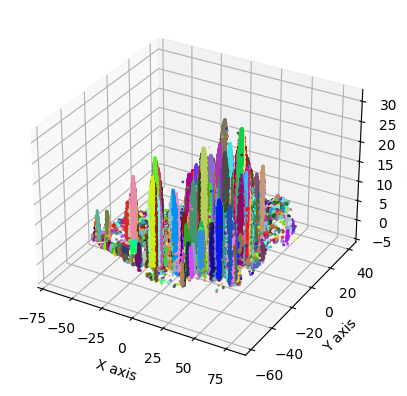

In [26]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud_big.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

total_points = len(las.x)
# Calculate the centroid
centroid = np.array([np.mean(x), np.mean(y), np.mean(z)])

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(z) - np.min(z)  # Maximum height of the point cloud

# Determine voxel indices
x_indices = np.floor((x - np.min(x)) / voxel_size_x).astype(int)
y_indices = np.floor((y - np.min(y)) / voxel_size_y).astype(int)
z_indices = np.floor((z - np.min(z)) / voxel_size_z).astype(int)

# Combine the indices to create unique voxel identifiers
voxel_indices = np.vstack((x_indices, y_indices, z_indices)).T

# Get unique voxels and their counts
unique_voxels, counts = np.unique(voxel_indices, axis=0, return_counts=True)

print(f"Number of unique voxels: {len(unique_voxels)}")

# Plotting the point cloud with different colors for each voxel
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assign a random color to each unique voxel
colors = np.random.rand(len(unique_voxels), 3)

# Plot each point with the color of its voxel
for i, voxel in enumerate(unique_voxels):
    mask = (voxel_indices == voxel).all(axis=1)
    ax.scatter(x[mask], y[mask], z[mask], color=colors[i], s=1)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [45]:
import laspy
import numpy as np
import open3d as o3d

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

total_points = len(las.x)
# Calculate the centroid
centroid = np.array([np.mean(x), np.mean(y), np.mean(z)])

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(z) - np.min(z) + 1  # Maximum height of the point cloud

# Determine voxel indices
x_indices = np.floor((x - np.min(x)) / voxel_size_x).astype(int)
y_indices = np.floor((y - np.min(y)) / voxel_size_y).astype(int)
z_indices = np.floor((z - np.min(z)) / voxel_size_z).astype(int)

# Combine the indices to create unique voxel identifiers
voxel_indices = np.vstack((x_indices, y_indices, z_indices)).T

# Get unique voxels and their counts
unique_voxels, counts = np.unique(voxel_indices, axis=0, return_counts=True)

print(f"Number of unique voxels: {len(unique_voxels)}")

# Create an Open3D point cloud
pcd = o3d.geometry.PointCloud()
points = np.vstack((x, y, z)).T
pcd.points = o3d.utility.Vector3dVector(points)

# Assign colors to each voxel
colors = np.random.rand(len(unique_voxels), 3)
colors_pointcloud = np.zeros((total_points, 3))

for i, voxel in enumerate(unique_voxels):
    mask = (voxel_indices == voxel).all(axis=1)
    colors_pointcloud[mask] = colors[i]

pcd.colors = o3d.utility.Vector3dVector(colors_pointcloud)

# Visualize the point cloud with Open3D
o3d.visualization.draw_geometries([pcd])


Centroid: [-26.62752109 -11.24297995   7.02195917]
Dimensions: [ 8.5725973  7.7568484 19.1077004]
total_points: 535079
Number of unique voxels: 18


In [43]:
import laspy
import numpy as np

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\strom_big.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

total_points = len(las.x)
# Calculate the centroid
centroid = np.array([np.mean(x), np.mean(y), np.mean(z)])

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(z) - np.min(z) + 1  # Maximum height of the point cloud

# Determine voxel indices
x_indices = np.floor((x - np.min(x)) / voxel_size_x).astype(int)
y_indices = np.floor((y - np.min(y)) / voxel_size_y).astype(int)
z_indices = np.floor((z - np.min(z)) / voxel_size_z).astype(int)

# Combine the indices to create unique voxel identifiers
voxel_indices = np.vstack((x_indices, y_indices, z_indices)).T

# Get unique voxels and their counts
unique_voxels, counts = np.unique(voxel_indices, axis=0, return_counts=True)

print(f"Number of unique voxels: {len(unique_voxels)}")
for voxel, count in zip(unique_voxels, counts):
    print(f"Voxel {voxel} contains {count} points")


KeyboardInterrupt: 

In [36]:
import laspy
import numpy as np

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud_big.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

total_points = len(las.x)
# Calculate the centroid
centroid = np.array([np.mean(x), np.mean(y), np.mean(z)])

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization with overlap
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(z) - np.min(z)  # Maximum height of the point cloud

# Define overlap ratio (e.g., 0.5 for 50% overlap)
overlap_ratio = float(input("Enter overlap ratio (0 to 1): "))

# Adjust voxel size to include overlap
adjusted_voxel_size_x = voxel_size_x * (1 - overlap_ratio)
adjusted_voxel_size_y = voxel_size_y * (1 - overlap_ratio)
adjusted_voxel_size_z = voxel_size_z * (1 - overlap_ratio)

# Determine voxel indices with overlap
x_indices = np.floor((x - np.min(x)) / adjusted_voxel_size_x).astype(int)
y_indices = np.floor((y - np.min(y)) / adjusted_voxel_size_y).astype(int)
z_indices = np.floor((z - np.min(z)) / adjusted_voxel_size_z).astype(int)

# Combine the indices to create unique voxel identifiers
voxel_indices = np.vstack((x_indices, y_indices, z_indices)).T

# Get unique voxels and their counts
unique_voxels, counts = np.unique(voxel_indices, axis=0, return_counts=True)

print(f"Number of unique voxels: {len(unique_voxels)}")


Centroid: [14.87639286 -6.08269449  5.71710509]
Dimensions: [147.519  98.631  33.795]
total_points: 2885171
Number of unique voxels: 2379


In [51]:
import laspy
import numpy as np

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

# Combine coordinates into a single array
points = np.vstack((x, y, z)).T

total_points = len(points)
# Calculate the centroid
centroid = np.mean(points, axis=0)

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization with overlap
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(z) - np.min(z) +1  # Maximum height of the point cloud

# Define overlap ratio (e.g., 0.5 for 50% overlap)
overlap_ratio = float(input("Enter overlap ratio (0 to 1): "))

# Adjust voxel size to include overlap
adjusted_voxel_size_x = voxel_size_x * (1 - overlap_ratio)
adjusted_voxel_size_y = voxel_size_y * (1 - overlap_ratio)
adjusted_voxel_size_z = voxel_size_z * (1 - overlap_ratio)

# Determine voxel indices with overlap
x_indices = np.floor((x - np.min(x)) / adjusted_voxel_size_x).astype(int)
y_indices = np.floor((y - np.min(y)) / adjusted_voxel_size_y).astype(int)
z_indices = np.floor((z - np.min(z)) / adjusted_voxel_size_z).astype(int)

# Combine the indices to create unique voxel identifiers
voxel_indices = np.vstack((x_indices, y_indices, z_indices)).T

# Get unique voxels and their counts
unique_voxels, counts = np.unique(voxel_indices, axis=0, return_counts=True)

print(f"Number of unique voxels: {len(unique_voxels)}")

# Divide each voxel into blocks with 1024 points (input to PointNet++) with overlap using Farthest Point Sampling
block_size = 1024
block_overlap_ratio = float(input("Enter block overlap ratio (0 to 1): "))
blocks = []

def farthest_point_sampling(points, n_samples):
    sampled_indices = [np.random.randint(len(points))]
    distances = np.full(len(points), np.inf)
    
    for _ in range(1, n_samples):
        last_sampled = points[sampled_indices[-1]].reshape(1, -1)
        dist = np.linalg.norm(points - last_sampled, axis=1)
        distances = np.minimum(distances, dist)
        sampled_indices.append(np.argmax(distances))
    
    return np.array(sampled_indices)

for voxel in unique_voxels:
    # Extract points in the current voxel
    mask = (voxel_indices == voxel).all(axis=1)
    voxel_points = points[mask]
    print(f"voxel {voxel_points} s {len(voxel_points)}")
    
    if len(voxel_points) < block_size:
        continue
    
    # Use Farthest Point Sampling to create blocks with overlap
    sampled_indices = set()
    
    while len(sampled_indices) < len(voxel_points):
        # Select a block using Farthest Point Sampling
        fps_indices = farthest_point_sampling(voxel_points, block_size)
        sampled_indices.update(fps_indices)
        blocks.append(voxel_points[fps_indices])
        # print(blocks)

print(f"Total number of blocks created: {len(blocks)}")


Centroid: [-26.62752109 -11.24297995   7.02195917]
Dimensions: [ 8.5725973  7.7568484 19.1077004]
total_points: 535079
Number of unique voxels: 18
voxel [[-30.75659942 -14.23740006   7.9731998 ]
 [-30.65239902 -14.29909996   7.9998002 ]
 [-30.73920062 -14.39179996   8.0543003 ]
 [-30.63969992 -14.20429996   8.0474005 ]
 [-30.93580052 -14.31550026   8.0921001 ]
 [-30.81920042 -14.29609966   8.2349997 ]
 [-30.61289982 -14.24230006   8.0817003 ]
 [-30.89100072 -14.32289986   8.2525997 ]
 [-30.93440052 -14.28229996   8.1553001 ]
 [-30.87859912 -14.29909996   8.3112001 ]
 [-30.83079922 -14.14150046   8.2038002 ]
 [-30.89220052 -14.23740006   8.2467003 ]
 [-30.91110042 -14.24460026   8.2912998 ]
 [-30.86100002 -14.21020036   8.1297998 ]
 [-30.94720082 -14.34969996   8.2994003 ]
 [-30.91150092 -14.31389996   8.2917995 ]
 [-30.91640082 -14.35999966   8.3190002 ]
 [-30.87389942 -14.34739976   8.3359003 ]
 [-30.87140082 -14.31429956   8.3273001 ]
 [-30.89690022 -14.29469966   8.4005003 ]
 [-30.8

KeyboardInterrupt: 

In [74]:
import laspy
import numpy as np

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud_big.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

# Combine coordinates into a single array
points = np.vstack((x, y, z)).T

total_points = len(points)
# Calculate the centroid
centroid = np.mean(points, axis=0)

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization with overlap
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(z) - np.min(z)  + 1  # Maximum height of the point cloud

# Define overlap ratio (e.g., 0.5 for 50% overlap)
overlap_ratio = float(input("Enter overlap ratio (0 to 1): "))

# Adjust voxel size to include overlap
adjusted_voxel_size_x = voxel_size_x * (1 - overlap_ratio)
adjusted_voxel_size_y = voxel_size_y * (1 - overlap_ratio)
adjusted_voxel_size_z = voxel_size_z * (1 - overlap_ratio)

# Determine voxel indices with overlap
x_indices = np.floor((x - np.min(x)) / adjusted_voxel_size_x).astype(int)
y_indices = np.floor((y - np.min(y)) / adjusted_voxel_size_y).astype(int)
z_indices = np.floor((z - np.min(z)) / adjusted_voxel_size_z).astype(int)

print(x_indices)
# Combine the indices to create unique voxel identifiers
voxel_indices = np.vstack((x_indices, y_indices, z_indices)).T

# Get unique voxels and their counts
unique_voxels, counts = np.unique(voxel_indices, axis=0, return_counts=True)

print(f"Number of unique voxels: {len(unique_voxels)}")

# Divide each voxel into blocks with 1024 points (input to PointNet++) with overlap using optimized sampling
block_size = 1024
block_overlap_ratio = float(input("Enter block overlap ratio (0 to 1): "))
blocks = []

def random_sampling(points, n_samples):
    return np.random.choice(len(points), n_samples, replace=False)

for i, voxel in enumerate(unique_voxels):
    # Extract points in the current voxel
    mask = (voxel_indices == voxel).all(axis=1)
    voxel_points = points[mask]
    
    print(f"Voxel {i}: Number of points in voxel: {len(voxel_points)}")
    
    if len(voxel_points) < block_size:
        continue
    
    # Use Random Sampling to create blocks with overlap
    sampled_indices = set()
    block_count = 0
    
    while len(sampled_indices) < len(voxel_points):
        # Select a block using Random Sampling
        if len(voxel_points) > block_size:
            rs_indices = random_sampling(voxel_points, block_size)
        else:
            rs_indices = np.arange(len(voxel_points))
        sampled_indices.update(rs_indices)
        blocks.append(voxel_points[rs_indices])
        block_count += 1
    
    print(f"Voxel {i}: Number of blocks created: {block_count}")

print(f"Total number of blocks created: {len(blocks)}")


Centroid: [14.87639286 -6.08269449  5.71710509]
Dimensions: [147.519  98.631  33.795]
total_points: 2885171
[37 37 37 ... 59 58 57]
Number of unique voxels: 2378
Voxel 0: Number of points in voxel: 11
Voxel 1: Number of points in voxel: 78
Voxel 2: Number of points in voxel: 2
Voxel 3: Number of points in voxel: 1
Voxel 4: Number of points in voxel: 2
Voxel 5: Number of points in voxel: 11
Voxel 6: Number of points in voxel: 23
Voxel 7: Number of points in voxel: 14
Voxel 8: Number of points in voxel: 100
Voxel 9: Number of points in voxel: 194
Voxel 10: Number of points in voxel: 33
Voxel 11: Number of points in voxel: 3
Voxel 12: Number of points in voxel: 6
Voxel 13: Number of points in voxel: 50
Voxel 14: Number of points in voxel: 31
Voxel 15: Number of points in voxel: 7
Voxel 16: Number of points in voxel: 36
Voxel 17: Number of points in voxel: 18
Voxel 18: Number of points in voxel: 48
Voxel 19: Number of points in voxel: 87
Voxel 20: Number of points in voxel: 82
Voxel 21: Nu

KeyboardInterrupt: 

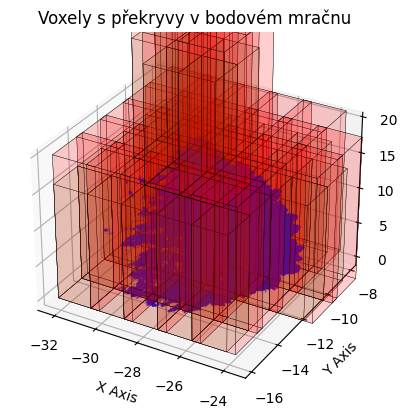

In [70]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

# Combine coordinates into a single array
points = np.vstack((x, y, z)).T

# Set up voxelization parameters
voxel_size_x = 2  # For illustration
voxel_size_y = 2
voxel_size_z = 20  # Maximum height of the point cloud
overlap_ratio = 0.2  # Overlap ratio

# Adjust voxel size to include overlap
adjusted_voxel_size_x = voxel_size_x * (1 - overlap_ratio)
adjusted_voxel_size_y = voxel_size_y * (1 - overlap_ratio)
adjusted_voxel_size_z = voxel_size_z * (1 - overlap_ratio)

# Determine voxel indices with overlap
x_indices = np.floor((x - np.min(x)) / adjusted_voxel_size_x).astype(int)
y_indices = np.floor((y - np.min(y)) / adjusted_voxel_size_y).astype(int)
z_indices = np.floor((z - np.min(z)) / adjusted_voxel_size_z).astype(int)

# Combine the indices to create unique voxel identifiers
voxel_indices = np.vstack((x_indices, y_indices, z_indices)).T

# Get unique voxels
unique_voxels = np.unique(voxel_indices, axis=0)

# Plot the point cloud with voxel boundaries
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the points
ax.scatter(x, y, z, s=0.1, c='b', alpha=0.5)

# Draw voxel boundaries as cubes
for voxel in unique_voxels:
    voxel_corner = np.array([
        np.min(x) + voxel[0] * adjusted_voxel_size_x,
        np.min(y) + voxel[1] * adjusted_voxel_size_y,
        np.min(z) + voxel[2] * adjusted_voxel_size_z
    ])

    # Define the vertices of the voxel cube
    vertices = [
        [voxel_corner[0], voxel_corner[1], voxel_corner[2]],
        [voxel_corner[0] + voxel_size_x, voxel_corner[1], voxel_corner[2]],
        [voxel_corner[0] + voxel_size_x, voxel_corner[1] + voxel_size_y, voxel_corner[2]],
        [voxel_corner[0], voxel_corner[1] + voxel_size_y, voxel_corner[2]],
        [voxel_corner[0], voxel_corner[1], voxel_corner[2] + voxel_size_z],
        [voxel_corner[0] + voxel_size_x, voxel_corner[1], voxel_corner[2] + voxel_size_z],
        [voxel_corner[0] + voxel_size_x, voxel_corner[1] + voxel_size_y, voxel_corner[2] + voxel_size_z],
        [voxel_corner[0], voxel_corner[1] + voxel_size_y, voxel_corner[2] + voxel_size_z]
    ]

    # Define the 6 faces of the voxel cube
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],
        [vertices[4], vertices[5], vertices[6], vertices[7]],
        [vertices[0], vertices[1], vertices[5], vertices[4]],
        [vertices[2], vertices[3], vertices[7], vertices[6]],
        [vertices[1], vertices[2], vertices[6], vertices[5]],
        [vertices[4], vertices[7], vertices[3], vertices[0]]
    ]

    # Create a 3D polygon collection for the voxel
    ax.add_collection3d(Poly3DCollection(faces, facecolors='r', linewidths=0.2, edgecolors='k', alpha=0.1))

# Draw overlap boundaries to visualize overlapping voxels
for voxel in unique_voxels:
    voxel_corner_overlap = np.array([
        np.min(x) + voxel[0] * adjusted_voxel_size_x,
        np.min(y) + voxel[1] * adjusted_voxel_size_y,
        np.min(z) + voxel[2] * adjusted_voxel_size_z
    ])

    # Define the vertices of the overlapping voxel cube
    vertices_overlap = [
        [voxel_corner_overlap[0], voxel_corner_overlap[1], voxel_corner_overlap[2]],
        [voxel_corner_overlap[0] + adjusted_voxel_size_x, voxel_corner_overlap[1], voxel_corner_overlap[2]],
        [voxel_corner_overlap[0] + adjusted_voxel_size_x, voxel_corner_overlap[1] + adjusted_voxel_size_y, voxel_corner_overlap[2]],
        [voxel_corner_overlap[0], voxel_corner_overlap[1] + adjusted_voxel_size_y, voxel_corner_overlap[2]],
        [voxel_corner_overlap[0], voxel_corner_overlap[1], voxel_corner_overlap[2] + adjusted_voxel_size_z],
        [voxel_corner_overlap[0] + adjusted_voxel_size_x, voxel_corner_overlap[1], voxel_corner_overlap[2] + adjusted_voxel_size_z],
        [voxel_corner_overlap[0] + adjusted_voxel_size_x, voxel_corner_overlap[1] + adjusted_voxel_size_y, voxel_corner_overlap[2] + adjusted_voxel_size_z],
        [voxel_corner_overlap[0], voxel_corner_overlap[1] + adjusted_voxel_size_y, voxel_corner_overlap[2] + adjusted_voxel_size_z]
    ]

    # Define the 6 faces of the overlapping voxel cube
    faces_overlap = [
        [vertices_overlap[0], vertices_overlap[1], vertices_overlap[2], vertices_overlap[3]],
        [vertices_overlap[4], vertices_overlap[5], vertices_overlap[6], vertices_overlap[7]],
        [vertices_overlap[0], vertices_overlap[1], vertices_overlap[5], vertices_overlap[4]],
        [vertices_overlap[2], vertices_overlap[3], vertices_overlap[7], vertices_overlap[6]],
        [vertices_overlap[1], vertices_overlap[2], vertices_overlap[6], vertices_overlap[5]],
        [vertices_overlap[4], vertices_overlap[7], vertices_overlap[3], vertices_overlap[0]]
    ]

    # Create a 3D polygon collection for the overlapping voxel
    ax.add_collection3d(Poly3DCollection(faces_overlap, facecolors='g', linewidths=0.2, edgecolors='k', alpha=0.05))

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.title('Voxely s překryvy v bodovém mračnu')

plt.show()


In [79]:
import laspy
import numpy as np

# Load the LAS file efficiently
with laspy.open(r"C:\Users\lukas\Desktop\pointcloud.las") as las_file:
    las = las_file.read()
    points = np.vstack((las.x, las.y, las.z)).T

# Calculate the total number of points
total_points = len(points)

# Calculate the centroid
centroid = np.mean(points, axis=0)

# Calculate the dimensions (range in each axis)
dimensions = np.ptp(points, axis=0)

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization with overlap
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(points[:, 2]) - np.min(points[:, 2]) + 1  # Maximum height of the point cloud

# Define voxel overlap ratio (e.g., 0.5 for 50% overlap)
voxel_overlap_ratio = float(input("Enter voxel overlap ratio (0 to 1): "))

# Adjust voxel size to include voxel overlap
adjusted_voxel_size_x = voxel_size_x * (1 - voxel_overlap_ratio)
adjusted_voxel_size_y = voxel_size_y * (1 - voxel_overlap_ratio)
adjusted_voxel_size_z = voxel_size_z * (1 - voxel_overlap_ratio)

# Determine voxel indices with overlap
voxel_indices = np.floor((points - np.min(points, axis=0)) / [adjusted_voxel_size_x, adjusted_voxel_size_y, adjusted_voxel_size_z]).astype(int)

# Get unique voxels and their counts
unique_voxels, counts = np.unique(voxel_indices, axis=0, return_counts=True)

print(f"Number of unique voxels: {len(unique_voxels)}")

# Divide each voxel into blocks with 1024 points (input to PointNet++) with variable block overlap
block_size = 1024
block_overlap_ratio = float(input("Enter block overlap ratio (0 to 1): "))
blocks = []

for i, voxel in enumerate(unique_voxels):
    # Extract points in the current voxel
    mask = (voxel_indices == voxel).all(axis=1)
    voxel_points = points[mask]
    
    print(f"Voxel {i}: Number of points in voxel: {len(voxel_points)}")
    
    if len(voxel_points) < block_size:
        continue
    
    # Create blocks with variable overlap
    overlap_points = int(block_size * block_overlap_ratio)
    start_idx = 0
    while start_idx + block_size <= len(voxel_points):
        block = voxel_points[start_idx:start_idx + block_size]
        blocks.append(block)
        start_idx += block_size - overlap_points  # Move forward by block size minus overlap to create variable overlap
    
   # print(f"Voxel {i}: Number of blocks created: {(len(blocks) - start_idx) // (block_size - overlap_points)}")

print(f"Total number of blocks created: {len(blocks)}")


Centroid: [-26.62752109 -11.24297995   7.02195917]
Dimensions: [ 8.5725973  7.7568484 19.1077004]
total_points: 535079
Number of unique voxels: 18
Voxel 0: Number of points in voxel: 24
Voxel 1: Number of points in voxel: 170
Voxel 2: Number of points in voxel: 2390
Voxel 3: Number of points in voxel: 11448
Voxel 4: Number of points in voxel: 10680
Voxel 5: Number of points in voxel: 6078
Voxel 6: Number of points in voxel: 19662
Voxel 7: Number of points in voxel: 26711
Voxel 8: Number of points in voxel: 32239
Voxel 9: Number of points in voxel: 65543
Voxel 10: Number of points in voxel: 59763
Voxel 11: Number of points in voxel: 57839
Voxel 12: Number of points in voxel: 6073
Voxel 13: Number of points in voxel: 63487
Voxel 14: Number of points in voxel: 124734
Voxel 15: Number of points in voxel: 43531
Voxel 16: Number of points in voxel: 151
Voxel 17: Number of points in voxel: 4556
Total number of blocks created: 641
